In [1]:
import sqlite3 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import requests
import numpy as np
from datetime import date, datetime
import time
import pymongo
import seaborn as sns
import os

import dotenv
from dotenv import load_dotenv

%load_ext autoreload
%autoreload 2

In [2]:
!pip install pandasql

In [3]:
!pip install python-dotenv

In [4]:
#connect to the database and create a cursor
con = sqlite3.connect('database.sqlite')
cur = con.cursor()

In [5]:
#fecth all the table names
query = """SELECT name FROM sqlite_master
         WHERE type='table'
         ORDER BY name"""

cur.execute(query).fetchall()

[('Matches',),
 ('Teams',),
 ('Teams_in_Matches',),
 ('Unique_Teams',),
 ('sqlite_sequence',)]

In [6]:
#create a dataframe from the db table filtering for 2011 season and German League

matches = cur.execute("""select *
            from Matches 
            where Season = 2011
            AND ((Div = 'D1' OR Div='D2'))""").fetchall()

df_matches = pd.DataFrame(matches)
df_matches. columns = [i[0] for i in cur.description]


dates = df_matches['Date'].unique()


### 1. The name of the team
### 2. The total number of goals scored by the team during the 2011 season for the German Leagues
### 3. The total number of wins the team earned during the 2011 season

In [7]:
query = cur.execute("""
  SELECT
         ut.Unique_Team_ID, ut.TeamName,
                 sum(case
                       when ut.TeamName=m.HomeTeam
                       then m.FTHG
                       end) as goalshome,
               sum( case
                   when ut.TeamName=m.AwayTeam
                   then m.FTAG
                   else 0
                   end) as goalsaway,
               count(case
                    when ut.TeamName=m.HomeTeam
                    and m.FTR='H'
                    then 1 else NULL END
                    ) as homewins,
               count(case
                    when ut.TeamName=m.HomeTeam
                    and m.FTR='A'
                    then 1 else NULL END
                     ) as homelosses,
               count(case
                    when ut.TeamName=m.AwayTeam
                    and m.FTR='A'
                    then 1 else NULL END
                    ) as awaywins,
               count(case
                     when ut.TeamName=m.AwayTeam
                     and m.FTR='H'
                     then 1 else NULL END
                     ) as awaylosses
               from Unique_Teams ut
                   join Teams_in_Matches tm
                       on ut.Unique_Team_ID=tm.Unique_Team_ID
                   join Matches m
                       on m.Match_ID=tm.Match_ID
               where m.Season = 2011
                   and ((Div = 'D1' OR Div='D2'))
               group by ut.Unique_Team_ID
               order by ut.TeamName;
""").fetchall()



In [8]:
full_df = pd.DataFrame(query)
full_df.columns = [i[0] for i in cur.description]

full_df.head()

,Unique_Team_ID,TeamName,goalshome,goalsaway,homewins,homelosses,awaywins,awaylosses
0,34,Aachen,15,15,4,7,2,8
1,15,Augsburg,20,16,6,4,2,8
2,1,Bayern Munich,49,28,14,2,9,5
3,28,Bochum,23,18,7,7,3,10
4,23,Braunschweig,21,16,6,3,4,6


## 4. A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly)

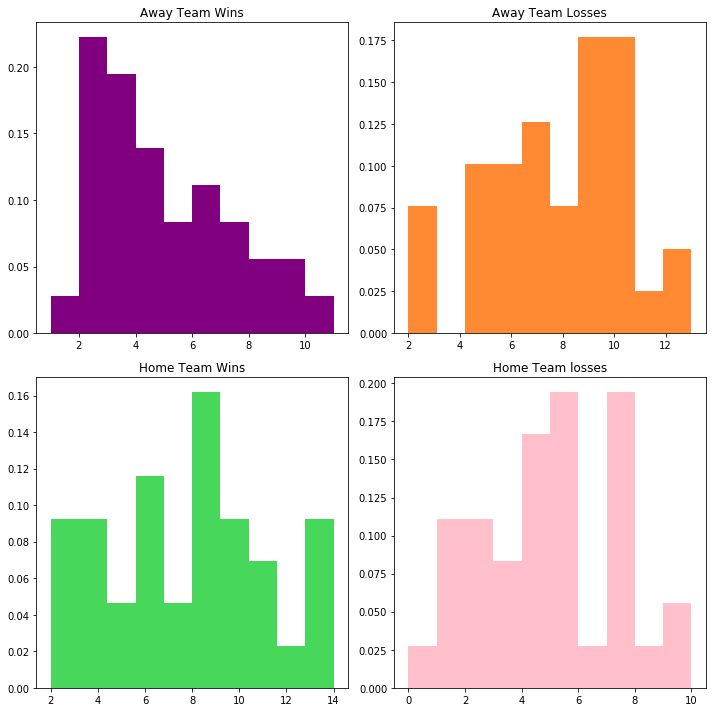

<Figure size 432x288 with 0 Axes>

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax0, ax1, ax2, ax3 = axes.flatten()


ax0.hist(full_df['awaywins'], bins = 10, color='purple', density = True)
ax0.set_title('Away Team Wins')

ax1.hist(full_df['awaylosses'],bins = 10,  color='#ff8a33', density = True)
ax1.set_title('Away Team Losses')

ax2.hist(full_df['homewins'], bins = 10, color='#47D85B', density = True)
ax2.set_title('Home Team Wins')

ax3.hist(full_df['homelosses'],bins = 10,  color='pink', density = True)
ax3.set_title('Home Team losses')

fig.tight_layout()
plt.show()

plt.savefig('histograms.png')

### API: Weather Data

In [65]:
# API format:
# Berlin lat 52.5200, long 13.4050
# API data format [YYYY]-[MM]-[DD]T[HH]:[MM]:[SS][timezone]. timezone


load_dotenv()

class WeatherGetter():

    def __init__(self):
        # Let's set our secrets and keys from the .env file
        # as environment variables.
        self.BASE_URL = 'https://api.darksky.net'
        self.token = os.getenv('DARKSKY_KEY')

#         if len(self.token) == 0:
#             raise ValueError('Missing API key!')
    
    def getForecast(self, date=list):
        weather_dates={}

        for date in dates_list:
            weather = requests.get(f'https://api.darksky.net/forecast/{self.token}/52.5200, 13.4050, {date}').json()
#         daily = weather['currently']
#         data = daily['data']
#         data = data[0]
#         data = data['icon']
#         weather_dates[date] = data
        return weather

In [66]:
unique = df_matches['Date'].unique()

dates_list = []

for datetime in unique:
    dates_list.append(datetime + "T20:00:00")
    
len(dates_list)

136

In [67]:
#create a class instance 
call = WeatherGetter()

In [71]:
#call the calss method 
weather_dates = call.getForecast(dates_list)

In [ ]:
#get the json result into a dataframe
weather_df = pd.DataFrame(list(weather_dates.items()), columns=['date', 'DateValue'])

In [ ]:
#to simplify the merge I create a new column that matches the date format in the json file
df_matches['date']= df_matches['Date'].map(lambda x: x + "T20:00:00")

In [ ]:
matches_weather_df = pd.merge(df_matches, weather_df, on='date')

In [ ]:
matches_weather_df['DateValue'].unique()

In [ ]:
matches_weather_df['rain'] = matches_weather_df['DateValue'].apply(lambda x: 1 if x=='Rain' else (1 if x=='Light Rain' else 0) )

In [ ]:
matches_weather_df['rain_home_win'] =np.where(np.logical_and(matches_weather_df['FTR']=='H',matches_weather_df['rain']==1),1,0)

In [ ]:
matches_weather_df['rain_away_win'] =np.where(np.logical_and(matches_weather_df['FTR']=='H',matches_weather_df['rain']==1),1,0)

In [ ]:
hometeam = matches_weather_df.groupby(['HomeTeam']).sum()

hometeam['Team']= hometeam.index

home = hometeam.loc[:,['Team','rain_home_win', 'rain']]

In [ ]:
awayteam = matches_weather_df.groupby(['AwayTeam']).sum()
awayteam['Team']= hometeam.index
away = awayteam.loc[:,['Team', 'rain_away_win','rain']]

In [ ]:
rain_wins = pd.merge(away, home, on ='Team')

In [ ]:
rain_wins.groupby('Team').sum()

rain_wins['total']=rain_wins['rain_home_win']+rain_wins['rain_away_win']

rain_wins['total_rain'] = rain_wins['rain_x']+rain_wins['rain_y']

In [ ]:
per_win = rain_wins.groupby('Team').sum()

per_win['percentage'] = per_win['total']/per_win['total_rain']

In [ ]:
per_win['team'] = per_win.index

## From DataFrame to MongoDB

In [ ]:
mongodata = pd.merge(totalwinloss,per_win, on='team')

In [ ]:
mymongo = pymongo.MongoClient("mongodb://127.0.0.1:27017/")

In [ ]:
mymongo

In [ ]:
mydb = mymongo['teams_data']

In [ ]:
mycollection = mydb['myteams']

In [ ]:
mydict = list(mongodata.to_dict(orient='records'))


In [ ]:
mycollection.insert_many(mydict)